In [ ]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2
import os

In [ ]:
from google.colab import drive
def initial_mount():
  drive.mount('/content/drive')

# to do when finish working
def flush_changes():
  drive.flush_and_unmount()
  print('All changes made in this colab session should now be visible in Drive.')
initial_mount()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# global parameters
ROOT_FOLDER = '/content/drive/My Drive/Colab Notebooks/DSApps_snacks' # colab path
# ROOT_FOLDER = r'C:\Users\maybe\DSApps\snacks_project\project_images\foods_final' # local path
folders_name = ["cakes_cupcakes_snack_cakes", "candy", "chips_pretzels_snacks", "chocolate", "cookies_biscuits", "popcorn_peanuts_seeds_related_snacks"]

TRAIN_VALID = 'foods_train_valid'
FOOD_FINAL = 'foods_final'

## Creating Color's Histogram Of The "Average" Image By Category 

In [ ]:
def load_images(imgs_df, folder_name):
  """
  Create dataframe from images by category, resize to 140x140 and reduce to rgb only (some images contains alpha layer).
  """
  print(f"starting working on {folder_name}")
  loop = 0
  for entry in os.scandir(f"{ROOT_FOLDER}/train/{folder_name}"):
    loop += 1
    file = entry.name
    img_full_path = os.path.join(ROOT_FOLDER, 'train', folder_name, file)
    img = imread(img_full_path)
    img_resize = cv2.resize(img, (140, 140))
    imgs_df = imgs_df.append({'idx': file[:-4], 'img': img_resize[:,:,:3], 'category': folder_name}, ignore_index=True)
    if loop % 1000 == 0:
      print(f"{loop}: {img_resize.shape} - {str(datetime.now().time())}")
  return imgs_df

# define final dataframe with all images (as numpy array) by category
cols = ['idx', 'img', 'category']
imgs_df = pd.DataFrame(columns=cols)
# iterate over folders
for folder in folders_name:
    imgs_df = load_images(imgs_df, folder_name=folder)

In [ ]:
def histogram_by_category():
  """
  Create dataframe of average images by category and color
  """
  category_hist = pd.DataFrame()
  for group, imgs in tqdm(imgs_df.groupby('category')['img']):
    mean_imgs = np.zeros_like(imgs.iloc[0], dtype=np.float64)
    for im in imgs:
      mean_imgs += im.astype(np.float64) / len(imgs)
    
    # color = ('r','g','b')
    category_hist[f'{group}_r'] = mean_imgs[:,:,0].flatten()
    category_hist[f'{group}_g'] = mean_imgs[:,:,1].flatten()
    category_hist[f'{group}_b'] = mean_imgs[:,:,2].flatten()

  return category_hist

test_hist = histogram_by_category()

 33%|███▎      | 2/6 [00:00<00:00,  8.00it/s]

(140, 140)
(140, 140)


 83%|████████▎ | 5/6 [00:00<00:00,  8.29it/s]

(140, 140)
(140, 140)
(140, 140)


100%|██████████| 6/6 [00:00<00:00,  8.43it/s]

(140, 140)


In [ ]:
test_hist.head()

,cakes_cupcakes_snack_cakes_r,cakes_cupcakes_snack_cakes_g,cakes_cupcakes_snack_cakes_b,candy_r,candy_g,candy_b,chips_pretzels_snacks_r,chips_pretzels_snacks_g,chips_pretzels_snacks_b,chocolate_r,chocolate_g,chocolate_b,cookies_biscuits_r,cookies_biscuits_g,cookies_biscuits_b,popcorn_peanuts_seeds_related_snacks_r,popcorn_peanuts_seeds_related_snacks_g,popcorn_peanuts_seeds_related_snacks_b
0,209.519270,205.567951,202.795132,234.359862,229.351211,225.871972,240.879070,239.831008,236.893023,235.381057,232.526432,229.409692,229.643299,226.286598,224.173196,242.892019,242.571205,240.965571
1,209.935091,206.087221,203.182556,233.787197,228.906574,225.288927,240.381395,239.145736,236.184496,234.814978,232.000000,228.995595,228.964948,225.575258,223.682474,242.478873,241.976526,240.427230
2,210.225152,206.395538,203.373225,233.015571,228.401384,224.332180,239.933333,238.367442,235.409302,234.581498,231.574890,228.407489,229.098969,225.744330,224.006186,241.971831,241.328638,239.820031
3,210.383367,206.632860,203.509128,232.359862,228.077855,223.833910,240.134884,238.561240,235.441860,234.339207,231.099119,228.011013,229.348454,226.154639,224.317526,242.026604,241.233177,239.560250
4,210.584178,206.851927,203.647059,232.674740,228.131488,223.965398,240.156589,238.573643,235.141085,234.350220,230.854626,227.790749,229.577320,226.531959,224.672165,241.862285,241.068858,239.222222


In [ ]:
# save dataframe to csv
test_hist.to_csv(f"{ROOT_FOLDER}/category_hist_by_rgb.csv", header=True, index=False)

## Creating Images Folders According To R Split

I want to split the images in the same order as I splitted in R. This code splits train images directory according to R split.

In [ ]:
# path to csv files which contain the images name splited by R
train_valid_sep_files = [("validation", f'{ROOT_FOLDER}/correct_model/test_idx_category.csv'),
                         ("train", f'{ROOT_FOLDER}/correct_model/train_idx_category.csv')]

def _copy(self, target):
  """
  copy file to target path
  source: https://stackoverflow.com/questions/33625931/copy-file-with-pathlib-in-python
  """
  import shutil
  assert self.is_file()
  shutil.copy(self, target)

# add custom function to `Path` (python object from pathlib)
Path.copy = _copy

def copy_file_to_folder(src_file, dst_dir, file_name):
  """
  copy file to target folder, create folder if not exists
  """
  if not dst_dir.exists():
    dst_dir.mkdir(parents=True, exist_ok=True)
  dst_file = dst_dir / f"{file_name}.jpg"
  src_file.copy(dst_file)

def copy_by_df(df_path, dir_type):
  """
  iterate over dataframe rows and copy images according it
  """
  # destination folder (new folders orders)
  train_valid_dir = Path(f'{ROOT_FOLDER}/correct_model/foods_train_valid') # new dir
  train_dir = Path(f'{ROOT_FOLDER}/foods_final/train') # old dir
  index_df = pd.read_csv(df_path)
  
  print(f'Starting copying {dir_type}')
  for index, row in index_df.iterrows():
    src_file = train_dir / row['category'] / f"{row['idx']}.jpg"
    # dir_type - train / validation
    dst_dir = train_valid_dir / dir_type / row['category']
    copy_file_to_folder(src_file, dst_dir , file_name=row['idx'])
  print(f'Done copying to {dir_type}, number of files: {len(index_df)}')

# run over train/validation csv files
for dir_type, dir_path in train_valid_sep_files:
  copy_by_df(df_path=dir_path, dir_type=dir_type)

Starting copying validation
Done copying to validation, number of files: 6348
Starting copying train
Done copying to train, number of files: 25403


# Only Images Model - New

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from keras import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# check if GPU if available on Google Colab 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


TRAIN_VALID = 'foods_train_valid'

Found GPU at: /device:GPU:0


In [ ]:
# images parameters
img_height, img_width = 100, 100
batch_size = 50
train_data_dir = f"{ROOT_FOLDER}/correct_model/{TRAIN_VALID}/train"
validation_data_dir = f"{ROOT_FOLDER}/correct_model/{TRAIN_VALID}/validation"

with tf.device('/device:GPU:0'):  # use GPU
  train_datagen = ImageDataGenerator(rescale=1./255) 

  # data generator for validation set 
  validation_datagen = ImageDataGenerator(rescale=1./255) 

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      color_mode = "rgb",
      batch_size=batch_size,
      shuffle = True,
      seed=123,
      interpolation='bilinear',
      subset='training') 

  validation_generator = validation_datagen.flow_from_directory(
      validation_data_dir, 
      target_size=(img_height, img_width),
      batch_size=batch_size,
      color_mode = "rgb",
      shuffle = False, 
      seed=123,
      interpolation='bilinear' )

Found 25403 images belonging to 6 classes.
Found 6348 images belonging to 6 classes.


In [ ]:
nb_epochs = 50
with tf.device('/device:GPU:0'):  # use GPU
  # neural network model
  model = Sequential()
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(6, activation='softmax'))

  model.compile(loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

  callback = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

  history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_data=validation_generator, 
      validation_steps=validation_generator.samples // batch_size,
      epochs=nb_epochs,
      batch_size=batch_size,
      callbacks=callback)

Epoch 1/50
508/508 [==============================] - 10751s 21s/step - loss: 1.5950 - accuracy: 0.3496 - val_loss: 1.4470 - val_accuracy: 0.4300
Epoch 2/50
508/508 [==============================] - 69s 137ms/step - loss: 1.3998 - accuracy: 0.4636 - val_loss: 1.3217 - val_accuracy: 0.5046
Epoch 3/50
508/508 [==============================] - 70s 138ms/step - loss: 1.2825 - accuracy: 0.5159 - val_loss: 1.2492 - val_accuracy: 0.5317
Epoch 4/50
508/508 [==============================] - 70s 138ms/step - loss: 1.1751 - accuracy: 0.5647 - val_loss: 1.2477 - val_accuracy: 0.5484
Epoch 5/50
508/508 [==============================] - 70s 138ms/step - loss: 1.0797 - accuracy: 0.6069 - val_loss: 1.1852 - val_accuracy: 0.5721
Epoch 6/50
508/508 [==============================] - 70s 138ms/step - loss: 0.9755 - accuracy: 0.6451 - val_loss: 1.1682 - val_accuracy: 0.5879
Epoch 7/50
508/508 [==============================] - 70s 138ms/step - loss: 0.8861 - accuracy: 0.6833 - val_loss: 1.1660 - val_a

In [ ]:
# save model
model.save(f"{ROOT_FOLDER}/correct_model/nn_model_images_only_new.h5")

# Nueral Network - Images + Final Features From R - New

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.layers import Input, Concatenate, Activation
from keras.layers.merge import concatenate
from keras.models import load_model
from keras.utils import plot_model
from keras import Model
import re

### Numerical Features
A csv files containing numerical feature after preprocessing and feature extrection.

In [ ]:
# train numerical feature processed in R
train_combained_df = pd.read_csv(f'{ROOT_FOLDER}/correct_model/train_combained_for_python.csv')
train_combained_df.drop('category', axis=1, inplace=True)

In [ ]:
# validation numerical feature processed in R
validation_combained_df = pd.read_csv(f'{ROOT_FOLDER}/correct_model/validation_combained_for_python.csv')
validation_combained_df.drop('category', axis=1, inplace=True)

In [ ]:
train_combained_df.shape

(25403, 277)

### Images and Feature Generator
A generator class which generate images, numerical features and lables in a batch.

In [ ]:
# images parameters
img_height, img_width = 100, 100
batch_size = 50
train_data_dir = f"{ROOT_FOLDER}/correct_model/{TRAIN_VALID}/train"
validation_data_dir = f"{ROOT_FOLDER}/correct_model/{TRAIN_VALID}/validation"

In [ ]:
class ImageWithNames(DirectoryIterator):
  """
  Create customize `DirectoryIterator` (from tensorflow) to generate images, row from dataframe and labels.
  from: https://stackoverflow.com/questions/41715025/keras-flowfromdirectory-get-file-names-as-they-are-being-generated
  """
  def __init__(self, *args, df_attr=None, **kwargs):
    super().__init__(*args, **kwargs)
    # file names as numpy array
    self.filenames_np = np.array(self.filenames)
    # dataframe of numerical features processed in R
    self.df_attr = df_attr

  def get_idx_row_as_np(self, row_idx):
    """
    Extract row by `idx` and convert to numpy array
    """
    selected = self.df_attr[self.df_attr['idx'] == int(re.findall(r'\d+', row_idx)[0])]
    # remove idx from selected row (the model shouldn't get idx)
    select_witout_idx = selected.loc[:, ~selected.columns.isin(['idx'])]
    return np.array(select_witout_idx.values[0], dtype=np.float32)


  def _get_batches_of_transformed_samples(self, index_array):
    """
    new implementation for `_get_batches_of_transformed_samples` to add row of numerical feature processed in R. 
    """
    if self.df_attr.empty is not None:
      # self.filenames_np[index_array] - get all batch file names
      attr_rows = np.array([self.get_idx_row_as_np(row_idx) for row_idx in self.filenames_np[index_array]], dtype=np.float32)
      
      if self.class_mode is not None:
        # For train and validation only: return images and features and y  
        x, y = super()._get_batches_of_transformed_samples(index_array)
        return [x, attr_rows], y
      else:
        # for test: return images and features only
        return [super()._get_batches_of_transformed_samples(index_array), attr_rows]

##  Images + Features Model

In [ ]:
# images parameters
img_height, img_width = 100, 100
batch_size = 32
train_data_dir = f"{ROOT_FOLDER}/correct_model/{TRAIN_VALID}/train"
validation_data_dir = f"{ROOT_FOLDER}/correct_model/{TRAIN_VALID}/validation"

In [ ]:
# create images and dataframe generator
with tf.device('/device:GPU:0'): # use GPU
  train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range = 30,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2
    ) 

  # data generator for validation set 
  validation_datagen = ImageDataGenerator(rescale=1./255) 

  train_generator = ImageWithNames(
      train_data_dir,
      train_datagen,
      df_attr=train_combained_df,
      target_size=(img_height, img_width),
      color_mode = "rgb",
      batch_size=batch_size,
      shuffle = True,
      seed=123,
      interpolation='bilinear',
      subset='training') 

  validation_generator = ImageWithNames(
      validation_data_dir,
       validation_datagen,
      df_attr=validation_combained_df,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      color_mode = "rgb",
      shuffle = False, 
      seed=123,
      interpolation='bilinear') 

Found 25403 images belonging to 6 classes.
Found 6348 images belonging to 6 classes.


In [ ]:
with tf.device('/device:GPU:0'):
  # Images Network
  images_in = Input(shape=(img_height, img_width, 3), name = 'img_model')

  images_out = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(images_in)
  images_out = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(images_out)
  images_out = MaxPooling2D(pool_size = (2,2))(images_out)

  images_out = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(images_out)
  images_out = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(images_out)
  images_out = MaxPooling2D(pool_size=(2,2))(images_out)

  images_out = Dropout(0.5)(images_out)
  images_out = Flatten()(images_out)

  img_model = Model(images_in, images_out)

In [ ]:
with tf.device('/device:GPU:0'):
  # Numerical Features Network
  atrr_in = Input(shape=(276,), name = 'attr_model')
  atrr_out = Dense(128, activation="relu")(atrr_in)
  atrr_out = Dropout(0.5)(atrr_out)
  atrr_out = Flatten()(atrr_out)

  attr_model = Model(atrr_in, atrr_out)

In [ ]:
nb_epochs = 50
with tf.device('/device:GPU:0'):
  concatenated = concatenate([images_out, atrr_out])
  out = Dense(6, activation='softmax')(concatenated)

  comb_model = Model([img_model.input, attr_model.input], out)

  comb_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

  callback = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

  history = comb_model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_data=validation_generator, 
      validation_steps=validation_generator.samples // batch_size,
      epochs=nb_epochs,
      batch_size=batch_size,
      callbacks=callback)

Epoch 1/50
793/793 [==============================] - 173s 218ms/step - loss: 0.4031 - accuracy: 0.8653 - val_loss: 0.2197 - val_accuracy: 0.9250
Epoch 2/50
793/793 [==============================] - 172s 217ms/step - loss: 0.2507 - accuracy: 0.9148 - val_loss: 0.2113 - val_accuracy: 0.9288
Epoch 3/50
793/793 [==============================] - 171s 216ms/step - loss: 0.2250 - accuracy: 0.9227 - val_loss: 0.2072 - val_accuracy: 0.9309
Epoch 4/50
793/793 [==============================] - 173s 219ms/step - loss: 0.2126 - accuracy: 0.9281 - val_loss: 0.2026 - val_accuracy: 0.9334
Epoch 5/50
793/793 [==============================] - 173s 218ms/step - loss: 0.2029 - accuracy: 0.9294 - val_loss: 0.2050 - val_accuracy: 0.9321
Epoch 6/50
793/793 [==============================] - 173s 219ms/step - loss: 0.1903 - accuracy: 0.9335 - val_loss: 0.2013 - val_accuracy: 0.9339
Epoch 7/50
793/793 [==============================] - 172s 217ms/step - loss: 0.1812 - accuracy: 0.9359 - val_loss: 0.2061 -

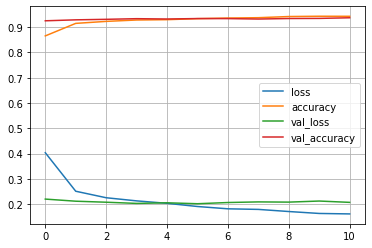

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

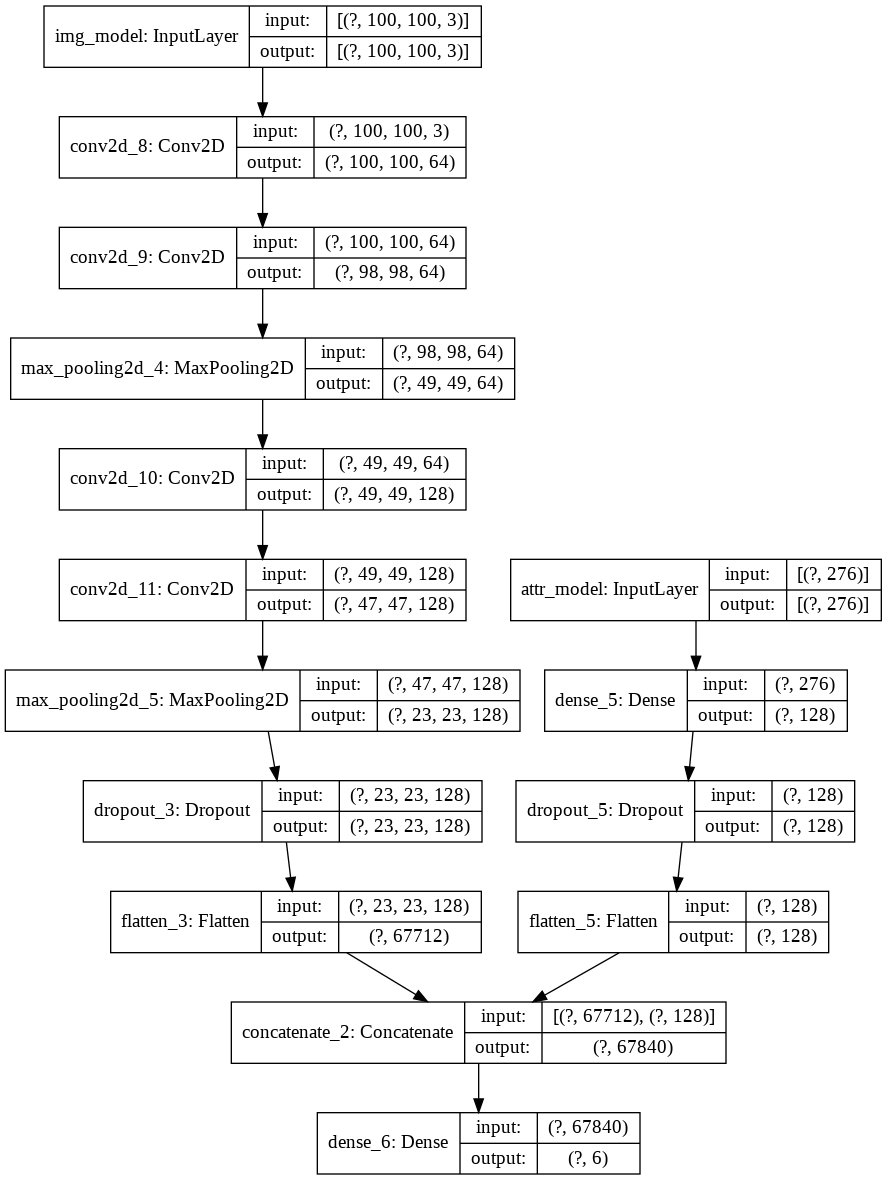

In [ ]:
plot_model(comb_model, f'{ROOT_FOLDER}/correct_model/comb_model_diagram_new.png', show_shapes=True)

In [ ]:
# save model
comb_model.save(f'{ROOT_FOLDER}/correct_model/final_nn_comb_model_images_numerical_new.h5')

# Nueral Network - Numerical Feature Only (From R) - New

In [ ]:
# read the numerical train data and drop idx
train_df = pd.read_csv(f'{ROOT_FOLDER}/correct_model/train_combained_for_python.csv')
train_df.drop('idx', axis=1, inplace=True)

# read the numerical validation data and drop idx
validation_df = pd.read_csv(f'{ROOT_FOLDER}/correct_model/validation_combained_for_python.csv')
validation_df.drop('idx', axis=1, inplace=True)

In [ ]:
# partition to data and lables
X_train = train_df.loc[:, ~train_df.columns.isin(['category'])]
y_train = train_df['category']

X_val = validation_df.loc[:, ~validation_df.columns.isin(['category'])]
y_val = validation_df['category']

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le = LabelEncoder()
le.fit(y_train)
# transform y labels to numerical
y_train_enc = to_categorical(le.transform(y_train), num_classes=6)
y_val_enc = to_categorical(le.transform(y_val), num_classes=6)

In [ ]:
nb_epochs = 50
batch_size = 32
with tf.device('/device:GPU:0'):
  atrr_in = Input(shape=(276,), name = 'attr_model')
  atrr_out = Dense(128, activation="relu")(atrr_in)
  atrr_out = Dropout(0.5)(atrr_out)
  atrr_out = Flatten()(atrr_out)
  atrr_out = Dense(6, activation='softmax')(atrr_out)

  attr_model = Model(atrr_in, atrr_out)

  attr_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

  callback = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

  attr_history = attr_model.fit(
      X_train,
      y_train_enc,
      steps_per_epoch=len(X_train) // batch_size,
      validation_data=(X_val, y_val_enc), 
      validation_steps=len(X_val) // batch_size,
      epochs=nb_epochs,
      batch_size=batch_size,
      callbacks=callback)

Epoch 1/50
793/793 [==============================] - 2s 3ms/step - loss: 0.4270 - accuracy: 0.8575 - val_loss: 0.2236 - val_accuracy: 0.9252
Epoch 2/50
793/793 [==============================] - 2s 3ms/step - loss: 0.2623 - accuracy: 0.9099 - val_loss: 0.2078 - val_accuracy: 0.9317
Epoch 3/50
793/793 [==============================] - 2s 3ms/step - loss: 0.2331 - accuracy: 0.9217 - val_loss: 0.2094 - val_accuracy: 0.9302
Epoch 4/50
793/793 [==============================] - 2s 3ms/step - loss: 0.2146 - accuracy: 0.9285 - val_loss: 0.2016 - val_accuracy: 0.9350
Epoch 5/50
793/793 [==============================] - 2s 3ms/step - loss: 0.1991 - accuracy: 0.9314 - val_loss: 0.2047 - val_accuracy: 0.9337
Epoch 6/50
793/793 [==============================] - 2s 3ms/step - loss: 0.1942 - accuracy: 0.9328 - val_loss: 0.2028 - val_accuracy: 0.9328
Epoch 7/50
793/793 [==============================] - 2s 3ms/step - loss: 0.1827 - accuracy: 0.9387 - val_loss: 0.2076 - val_accuracy: 0.9343
Epoch 

In [ ]:
# save model 
# model numerical only
attr_model.save(f'{ROOT_FOLDER}/correct_model/final_nn_numeric_only_new.h5')

# Test Prediction


In [ ]:
# load model
final_model = load_model(f'{ROOT_FOLDER}/correct_model/final_nn_comb_model_images_numerical_new.h5')

In [ ]:
test_combained_df = pd.read_csv(f'{ROOT_FOLDER}/correct_model/test_data_to_predict_python.csv')

In [ ]:
test_data_dir = f"{ROOT_FOLDER}/{FOOD_FINAL}"

with tf.device('/device:GPU:0'):
  # data generator for test set
  test_datagen = ImageDataGenerator(rescale = 1./255)
  # generator for reading test data from folder
  test_generator = ImageWithNames(
      test_data_dir,
      test_datagen,
      df_attr=test_combained_df,
      target_size = (img_height, img_width),
      seed=123,
      batch_size = 1,
      interpolation='bilinear',
      shuffle = False, 
      class_mode=None,
      classes=['test'])

Found 3525 images belonging to 1 classes.


In [ ]:
with tf.device('/device:GPU:0'):
  prediction = final_model.predict(
      test_generator,
      verbose=1,
      batch_size=batch_size,
      steps=test_generator.samples)

3525/3525 [==============================] - 1343s 381ms/step


In [ ]:
# use argmax to get model prediction lable
predicted_classes = np.argmax(prediction, axis=1)
# map class name to numeric according to training generator
l = {v: k for k,v in train_generator.class_indices.items()}
# convert each numeric prediction to lable name
pred_names = [l[k] for k in predicted_classes]
# get file names - sanity check
file_names = test_generator.filenames
# get indexes
idx_preds = [int(re.findall(r'\d+', f_name)[0]) for f_name in test_generator.filenames]

In [ ]:
len(file_names)

3525

In [ ]:
final_df = pd.DataFrame({'idx': idx_preds, 'Filename': file_names,'Prediction': pred_names})
final_df.head(5)

,idx,Filename,Prediction
0,10023,test/10023.jpg,chips_pretzels_snacks
1,10026,test/10026.jpg,popcorn_peanuts_seeds_related_snacks
2,10035,test/10035.jpg,cakes_cupcakes_snack_cakes
3,10036,test/10036.jpg,candy
4,10052,test/10052.jpg,popcorn_peanuts_seeds_related_snacks


In [ ]:
final_df.to_csv(f'{ROOT_FOLDER}/correct_model/final_nn_preds_03.csv', index = False)